In [74]:
import numpy as np
import matplotlib.pyplot as plt

wavelengths = np.arange(0.15, 2.6, 0.01)
freqs = 1e4 / wavelengths
nc = 40
charge = 1

In [2]:
def absorption_cross_section_org(f: np.ndarray) -> np.ndarray:
    """
    Calculates the PAH absorption cross-section per Li & Draine 2007,
    ApJ, 657:810-837.

    :Params f: frequencies in wavenumber

    :Returns: float array
    """

    wave = 1e4 / f

    A_c = [7.97e-17, 1.23e-17, 20e-21, 14e-21, 80e-24, 84e-24, 46e-24, -322e-24]
    W_c = [0.195, 0.217, 0.0805, 0.20, 0.0370, 0.0450, 0.0150, 0.135]
    C_c = [0.0722, 0.2175, 1.05, 1.23, 1.66, 1.745, 1.885, 1.90]

    A = np.transpose(np.resize(A_c, (np.size(f), np.size(A_c))))
    W = np.transpose(np.resize(W_c, (np.size(f), np.size(W_c))))
    C = np.transpose(np.resize(C_c, (np.size(f), np.size(C_c))))

    # Cutoff wavelength from Salama et al. (1996), over wavelength
    # (Eq. (4) in Mattioda et al. (2005))
    y = 1.0 / (0.889 + (2.282 / np.sqrt(0.4 * nc))) / wave

    wave_r2 = np.resize(wave, (2, (np.size(f))))

    crosssection = ((1.0 / np.pi) * np.arctan((1e3 * (y - 1.0) ** 3) / y) + 0.5) * (
        3458e-20 * 10.0 ** (-3.431 * wave)
        + (2.0 / np.pi)
        * np.sum(
            W[:2]
            * C[:2]
            * A[:2]
            / (((wave_r2 / C[:2]) - (C[:2] / wave_r2)) ** 2 + W[:2] ** 2),
            axis=0,
        )
    )

    # if charge != 0:
    #     wave_r6 = np.resize(wave, (6, np.size(f)))

    #     crosssection = (
    #         crosssection
    #         + np.exp(-1e-1 / wave**2) * 1.5e-19 * 10 ** (-wave)
    #         + np.sqrt(2.0 / np.pi)
    #         * np.sum(
    #             A[2:] * np.exp(-2.0 * (wave_r6 - C[2:]) ** 2 / W[2:] ** 2) / W[2:],
    #             axis=0,
    #         )
    #     )

    return crosssection

In [3]:
absorption_cross_section_org(freqs)

array([1.14394284e-17, 1.08428791e-17, 1.04698638e-17, 1.04270712e-17,
       1.09109000e-17, 1.21518201e-17, 1.37930514e-17, 1.39384328e-17,
       1.19059604e-17, 9.56766175e-18, 7.82017426e-18, 6.59826552e-18,
       5.71387978e-18, 5.03955509e-18, 4.50104631e-18, 4.05521978e-18,
       3.67610098e-18, 3.34731325e-18, 3.05803599e-18, 2.80079432e-18,
       2.57020895e-18, 2.36226362e-18, 2.17386052e-18, 2.00254158e-18,
       1.84630816e-18, 1.70350115e-18, 1.57271885e-18, 1.45275946e-18,
       1.34257965e-18, 1.24126404e-18, 1.14800221e-18, 1.06207085e-18,
       9.82819660e-19, 9.09659702e-19, 8.42053544e-19, 7.79506391e-19,
       7.21557624e-19, 6.67772005e-19, 6.17729648e-19, 5.71013415e-19,
       5.27191709e-19, 4.85793432e-19, 4.46270390e-19, 4.07941928e-19,
       3.69924566e-19, 3.31096528e-19, 2.90325671e-19, 2.47552728e-19,
       2.05785484e-19, 1.70550247e-19, 1.44917911e-19, 1.27710744e-19,
       1.16159048e-19, 1.07766932e-19, 1.00679958e-19, 9.35967664e-20,
      

In [4]:
@staticmethod
def absorption_cross_section_manuel(f: np.ndarray) -> np.ndarray:
    """
    Calculates the PAH absorption cross-section per Li & Draine 2007,
    ApJ, 657:810-837.

    :param f: Frequencies in wavenumber (can be a single float or np.ndarray).
    :return: Array of calculated cross-sections.
    """
    # Ensure `f` is treated as an array
    f = np.atleast_1d(f)

    # Convert frequency to wavelength
    wave = 1e4 / f

    # Initialize arrays for different models
    cross = np.zeros_like(f)
    cross1 = np.zeros_like(f)
    cross6 = np.zeros_like(f)

    # Set up parameters for Lorentz profile
    lamj = np.array([3.3, 6.2, 7.7, 8.6, 11.3, 11.9, 12.7, 16.4, 18.3, 21.2, 23.1, 26.0])
    gammaj = np.array([0.012, 0.032, 0.091, 0.047, 0.018, 0.025, 0.024, 0.010, 0.036, 0.038, 0.046, 0.69])
    aj = np.array([197 * 0.4, 19.6 * 3., 60.9 * 2, 34.7 * 2 * 0.4, 427 / 3. * 0.4, 
                    72.7 / 3. * 0.4, 167 / 3. * 0.4, 5.52, 6.04, 10.8, 2.78, 15.2]) * 1.0e-20

    # Calculate Lorentz profile (cross1) for each wavelength
    s_values = (2.0 / np.pi) * (gammaj * lamj * aj) / ((wave[:, None] / lamj - lamj / wave[:, None])**2 + gammaj**2)
    cross1 = 34.58 * 10**(-18 - 3.431 * wave) + np.sum(s_values, axis=1)


    # Gaussian model parameters
    l0 = np.array([1.05, 1.23, 1.66, 1.745, 1.885, 1.90])
    w = np.array([0.0805, 0.2, 0.037, 0.045, 0.015, 0.135])
    a = np.array([2e-20, 1.4e-20, 8e-23, 8.4e-23, 4.6e-23, 3.22e-22])

    # Calculate Gaussian model (cross6)
    g_values = (a / (w * np.sqrt(np.pi / 2))) * np.exp(-2 * (wave[:, None] - l0)**2 / w**2)
    cross6 = 1.5 * 10**(-19 - wave) + np.sum(g_values, axis=1) - g_values[:, -1]

    # Select final cross-section values based on wavelength threshold
    cross = np.where(wave <= 0.8, cross1, cross6)

    return cross

In [59]:
def absorption_cross_section_new(f: np.ndarray) -> np.ndarray:
    """
    Calculates the PAH absorption cross-section per
    - Li & Draine 2001b, ApJ, 554:778-802 Eq. [11] 
    - Li & Draine 2007, ApJ, 657:810-837. Table 1
    With NIR corrections from 
    - Mattioda et al. 2005c  
    - Mattioda et al. 2008. 

    :Params f: frequencies in wavenumber

    :Returns: float array
    """

    wave = 1e4 / f

    #entry 1 and 2 from Draine & Li (2007), (but these are not different from Li & Draine 2001),
    #entry 3-8 from Gaussian Parameters Mattioda et al. (2005c)
    # C_c = [0.0722, 0.2175, 1.05, 1.23, 1.66, 1.745, 1.885, 1.90]
    # W_c = [0.195, 0.217, 0.0805, 0.20, 0.0370, 0.0450, 0.0150, 0.135]
    # A_c = [7.97e-17, 1.23e-17, 20e-21, 14e-21, 80e-24, 84e-24, 46e-24, -322e-24]

    #entry 1 and 2 from Draine & Li (2007), (but these are not different from Li & Draine 2001), 
    #entry 3-5 from Drude Parameters Mattioda et al. (2008) table 3
    #entry 6 is one Gaussian Parameters Mattioda et al. (2008) table 3
    C_c = [0.0722, 0.2175, 1.05, 1.26, 1.905, 1.185]
    W_c = [0.195, 0.217, 0.055, 0.11, 0.09, 0.2985]
    A_c = [7.97e-17, 1.23e-17, 2e-20, 7.8e-21, 1.465e-22, 1.4e-20]

    C = np.transpose(np.resize(C_c, (np.size(f), np.size(C_c))))
    W = np.transpose(np.resize(W_c, (np.size(f), np.size(W_c))))
    A = np.transpose(np.resize(A_c, (np.size(f), np.size(A_c))))


    # Cutoff wavelength from Salama et al. (1996),
    # (Eq. (4) in Mattioda et al. (2005c)), adding in the correction for nc > 40
    if nc > 40: 
        y = 1.0 / (0.889 + (2.282 / np.sqrt(0.4 * nc))) / wave
    else:
        y = 1.0 / (0.889 + (2.282 / np.sqrt(0.3 * nc))) / wave

    #continuum from 0.07 - 0.82 μm according to Li & Draine (2001), Eq [11]
    wave_r2 = np.resize(wave, (2, (np.size(f))))
    crosssection_LD01 = ((1.0 / np.pi) * np.arctan((1e3 * (y - 1.0) ** 3) / y) + 0.5) * ( #implement cutoff wavelenght
        3458e-20 * 10.0 ** (-3.431 * wave) #continuum from Li & Draine (2001) Eq. 11 
        + (2.0 / np.pi) #Drude profile summation
        * np.sum(
            W[:2]
            * C[:2]
            * A[:2]
            / (((wave_r2 / C[:2]) - (C[:2] / wave_r2)) ** 2 + W[:2] ** 2),
            axis=0,
        )
    )

    #NIR correction from 0.82 μm according to Mattioda et al. (2008), Eq. (3), table 3
    wave_r6 = np.resize(wave, (6, np.size(f)))

    crosssection_NIR = (np.exp(-1e-1 / wave**2) * 1.4e-19 * 10 ** -0.2 * 10 ** (-1.34*wave)
        + np.sqrt(2.0 / np.pi)
        * np.sum(
            A[5:] * np.exp(-2.0 * (wave_r6 - C[5:]) ** 2 / W[5:] ** 2) / W[5:], #Gaussian profile summation
            axis=0,
        ))

    # crosssection_NIR = (np.exp(-1e-1 / wave**2) * 1.5e-19 * 10 ** (-wave)
    #     + np.sqrt(2.0 / np.pi)
    #     * np.sum(
    #         A[2:] * np.exp(-2.0 * (wave_r6 - C[2:]) ** 2 / W[2:] ** 2) / W[2:], #Gaussian profile summation
    #         axis=0,
    #     ))
    
    # crosssection_NIR = (3.5e-19 * 10 ** (-1.45 * wave) + np.sqrt(2.0 / np.pi)
    #     * np.sum(
    #         W[:2]
    #         * C[:2]
    #         * A[:2]
    #         / (((wave_r2 / C[:2]) - (C[:2] / wave_r2)) ** 2 + W[:2] ** 2),
    #         axis=0
    #     ))

    
    #0.07 - 0.7 μm: Draine & Li, 0.82 - 2.5 μm: Mattioda et al. (2008)
    crosssection = np.where(wave <= 0.82, crosssection_LD01, crosssection_NIR)

    return crosssection

In [60]:
result = absorption_cross_section_new(freqs)

In [7]:
#Draine & Li
f = freqs
wave = 1e4 / f

# lambda_D = [0.0722, 0.2175, 1.050, 1.260, 1.905]
# w_D = [0.195, 0.217, 0.055, 0.11, 0.09]
# A_D = [7.97e-13, 1.23e-13, 0, 0, 0]

lambda_D = [0.0722, 0.2175, 1.05, 1.23, 1.66, 1.745, 1.885, 1.90]
w_D = [0.195, 0.217, 0.0805, 0.20, 0.0370, 0.0450, 0.0150, 0.135]
A_D = [7.97e-17, 1.23e-17, 20e-21, 14e-21, 80e-24, 84e-24, 46e-24, -322e-24]

C = np.transpose(np.resize(lambda_D, (np.size(f), np.size(lambda_D))))
W = np.transpose(np.resize(w_D, (np.size(f), np.size(w_D))))
A = np.transpose(np.resize(A_D, (np.size(f), np.size(A_D))))

y = 1.0 / (0.889 + (2.282 / np.sqrt(0.4 * nc))) / wave

wave_r2 = np.resize(wave, (2, (np.size(f))))

crosssection_Draine = ((1.0 / np.pi) * np.arctan((1e3 * (y - 1.0) ** 3) / y) + 0.5) * (
    3458e-20 * 10.0 ** (-3.431 * wave)
    + (2.0 / np.pi)
    * np.sum(
        W[:2]
        * C[:2]
        * A[:2]
        / (((wave_r2 / C[:2]) - (C[:2] / wave_r2)) ** 2 + W[:2] ** 2),
        axis=0,
    )
)


In [8]:
#Mattioda et al. (2008)
wave_r6 = np.resize(wave, (6, np.size(f)))

crosssection_NIR = (np.exp(-1e-1 / wave**2) * 1.5e-19 * 10 ** (-wave)
    + np.sqrt(2.0 / np.pi)
    * np.sum(
        A[2:] * np.exp(-2.0 * (wave_r6 - C[2:]) ** 2 / W[2:] ** 2) / W[2:],
        axis=0,
    ))


In [9]:
crosssection = np.where(wave <= 0.7, crosssection_Draine, crosssection_NIR)

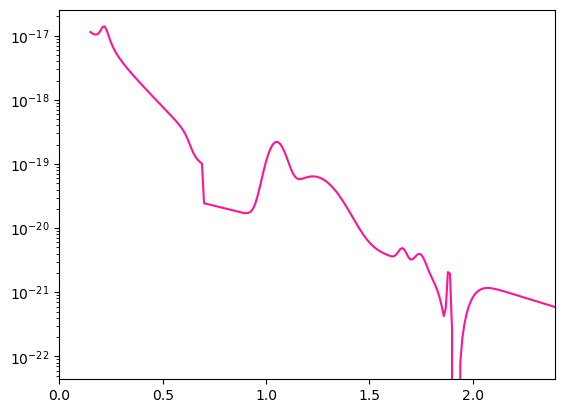

In [10]:
# plt.plot(wave, crosssection_Draine, label='Draine & Li', linestyle='dotted')
# plt.plot(wave, crosssection_NIR, label='Mattioda et al. (2008)')
plt.plot(wave, crosssection, label='Combined', color='deeppink')
plt.yscale('log')
plt.xlim(0,2.4)
plt.show()
  

In [57]:
manuel = absorption_cross_section_manuel(freqs)
org_nasa = absorption_cross_section_org(freqs)
new = absorption_cross_section_new(freqs)

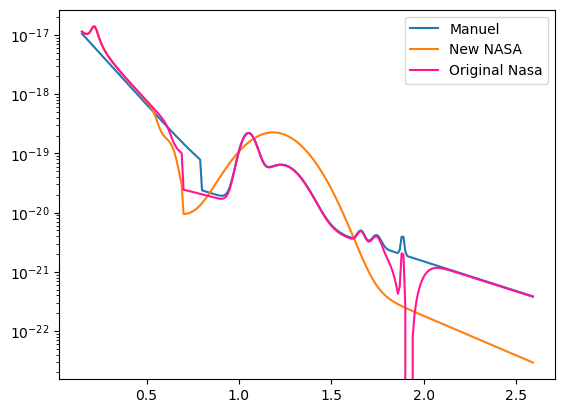

In [61]:
plt.plot(wave, manuel, label='Manuel')
# plt.plot(wave, org_nasa, label='Original NASA (Li & Draine 2007)')
plt.plot(wave, new, label='New NASA')
plt.plot(wave, crosssection, label='Original Nasa', color='deeppink')
# plt.plot(wave, absorption_cross_section_org(freqs), label='Original')
plt.legend()
plt.yscale('log')
plt.show()

In [13]:
#Gaussian 6 (Mattioda et al. 2005c)
k0 = [1.05, 1.23, 1.66, 1.745, 1.885, 1.90]
w = [0.0805, 0.20, 0.037, 0.045, 0.015, 0.135]
A = [2.0e-20, 1.4e-20, 8.0e-23, 8.4e-23, 4.6e-23, 3.22e-22]

#Drude 3 (Mattioda et al. 2008)
k0 = [1.05, 1.26, 1.905]
w = [0.055, 0.11, 0.09]
A = [2e-20, 7.8e-21, 1.465e-22]

#Gaussian 1 (Mattioda et al. 2008)
k0 = [1.185]
w = [0.2985]
A = [1.4e-20]

In [49]:
#check continuum terms
y1 = 3.5e-19 * 10**(-1.45/wave) * np.exp(-0.1*wave**2)
y2 = 3458e-20 * 10.0 ** (-3.431 * wave)
y3= 34.58e-18 * 10**(-3.431/wave)

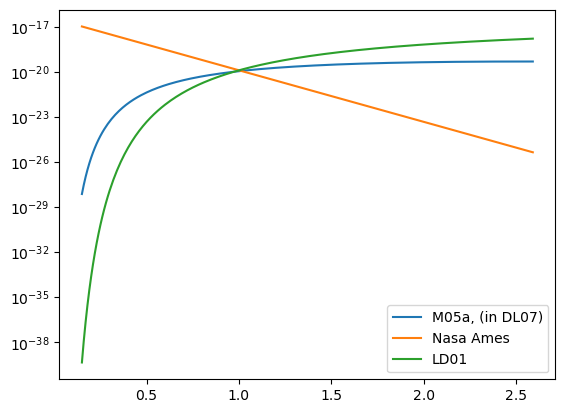

In [50]:
plt.plot(wave, y1, label='M05a, (in DL07)') #is it though??
plt.plot(wave, y2, label='Nasa Ames')
plt.plot(wave, y3, label='LD01')
plt.legend()
plt.yscale('log')
plt.show()

In [78]:
def absorption_cross_section_final(f: np.ndarray) -> np.ndarray:
    """
    Calculates the PAH absorption cross-section per
    - Li & Draine 2001b, ApJ, 554:778-802 Eq. [11] 
    - Draine & 2007, ApJ, 657:810-837. Table 1, same as Li & Draine 2001

    With NIR corrections from 
    - Mattioda et al. 2005c  
    - Mattioda et al. 2008. 

    :Params f: frequencies in wavenumber

    :Returns: float array
    """

    wave = 1e4 / f

    #entry 1 and 2 from Draine & Li (2007), (but these are not different from Li & Draine 2001), 
    #entry 3-5 from Drude Parameters Mattioda et al. (2008) table 3, not used
    #entry 6 is one Gaussian Parameters Mattioda et al. (2008) table 3
    C_c = [0.0722, 0.2175, 1.05, 1.26, 1.905, 1.185]
    W_c = [0.195, 0.217, 0.055, 0.11, 0.09, 0.2985]
    A_c = [7.97e-17, 1.23e-17, 2e-20, 7.8e-21, 1.465e-22, 1.4e-20]

    C = np.transpose(np.resize(C_c, (np.size(f), np.size(C_c))))
    W = np.transpose(np.resize(W_c, (np.size(f), np.size(W_c))))
    A = np.transpose(np.resize(A_c, (np.size(f), np.size(A_c))))


    # Cutoff wavelength from Salama et al. (1996),
    # (Eq. (4) in Mattioda et al. (2005c)), adding in the correction for nc > 40
    if nc > 40: 
        y = 1.0 / (0.889 + (2.282 / np.sqrt(0.4 * nc))) / wave
    else:
        y = 1.0 / (0.889 + (2.282 / np.sqrt(0.3 * nc))) / wave

    #continuum from 0.07 - 0.82 μm according to Li & Draine (2001), Eq [11]
    wave_r2 = np.resize(wave, (2, (np.size(f))))
    crosssection = ((1.0 / np.pi) * np.arctan((1e3 * (y - 1.0) ** 3) / y) + 0.5) * ( #implement cutoff wavelenght
        3458e-20 * 10.0 ** (-3.431 * wave) #continuum from Li & Draine (2001) Eq. 11 
        + (2.0 / np.pi) #Drude profile summation
        * np.sum(
            W[:2]
            * C[:2]
            * A[:2]
            / (((wave_r2 / C[:2]) - (C[:2] / wave_r2)) ** 2 + W[:2] ** 2),
            axis=0,
        )
    )
    if charge != 0:
        #NIR correction from 0.82 μm according to Mattioda et al. (2008), Eq. (3), table 3
        wave_r6 = np.resize(wave, (6, np.size(f)))

        crosssection = crosssection + (np.exp(-1e-1 / wave**2) * 1.4e-19 * 10 ** -0.2 * 10 ** (-1.34*wave)
            + np.sqrt(2.0 / np.pi)
            * np.sum(
                A[5:] * np.exp(-2.0 * (wave_r6 - C[5:]) ** 2 / W[5:] ** 2) / W[5:], #Gaussian profile summation
                axis=0,
            ))

    return crosssection

In [79]:
charge=0
final_0 = absorption_cross_section_final(freqs)
charge=1
final_1 = absorption_cross_section_final(freqs)

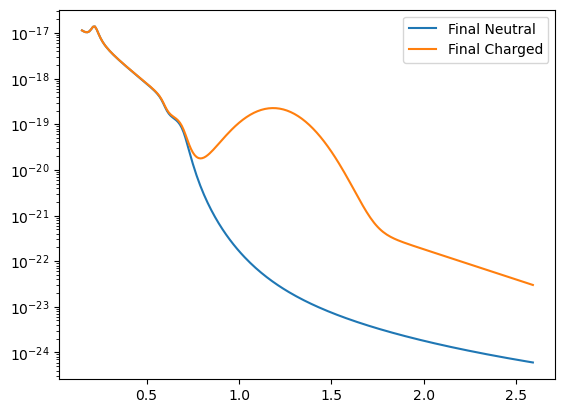

In [80]:
# plt.plot(wave, manuel, label='Manuel')
# plt.plot(wave, org_nasa, label='Original NASA (Li & Draine 2007)')
# plt.plot(wave, new, label='New NASA')
# plt.plot(wave, crosssection, label='Original Nasa', color='deeppink')
# plt.plot(wave, absorption_cross_section_org(freqs), label='Original')
plt.plot(wave, final_0, label='Final Neutral')
plt.plot(wave, final_1, label='Final Charged')
plt.legend()
plt.yscale('log')
plt.show()